# Init

In [1]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import skimage.measure
import skimage.util
import sklearn.datasets
import sklearn.metrics
import sklearn.neighbors
import sklearn.svm

In [2]:
sns.set(style='dark')
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['image.cmap'] = 'viridis'
np.set_printoptions(threshold=20, edgeitems=10, linewidth=140, precision=3, suppress=True)

# Extract hand written digits from an image

In [3]:
digits_rgb = cv2.imread('data/20181129_090521.jpg')[..., ::-1]
digits_rgb = cv2.resize(digits_rgb, (800, 600))

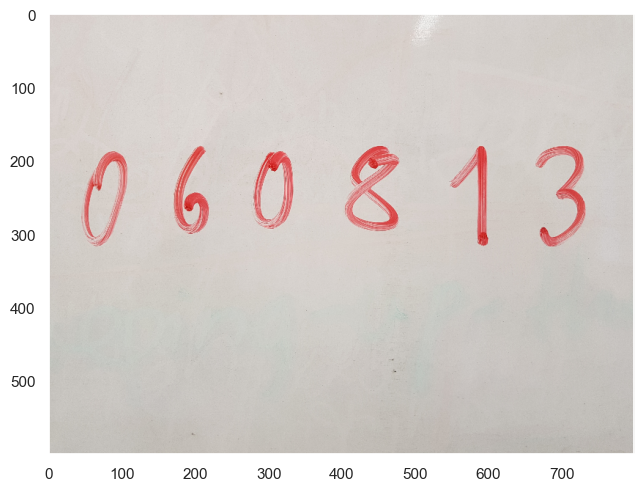

In [4]:
plt.imshow(digits_rgb);
# plt.show();

In [5]:
# enhance and extract the red component
# digits_r = digits_rgb[..., 0] / (digits_rgb[..., 0] + digits_rgb[..., 1] + digits_rgb[..., 2])  # uint8 overflow
digits_r = digits_rgb[..., 0] / digits_rgb.sum(axis=2)
# digits_r = 255 - digits_rgb[..., 1]  # also works
digits_r = np.uint8(255 * digits_r)

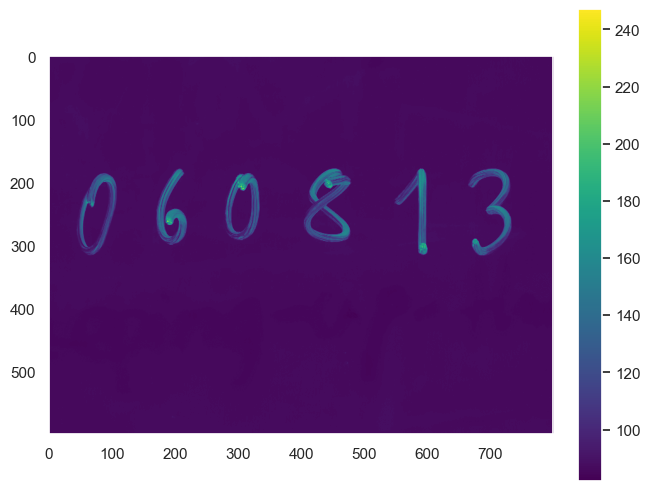

In [6]:
plt.imshow(digits_r)
plt.colorbar();

In [7]:
digits_thresh_val, _ = cv2.threshold(digits_r, 0, 255, cv2.THRESH_OTSU)
digits_thresh_val

110.0

In [8]:
digits_thresholded = digits_r > digits_thresh_val - 20
digits_thresholded = np.uint8(255 * digits_thresholded)

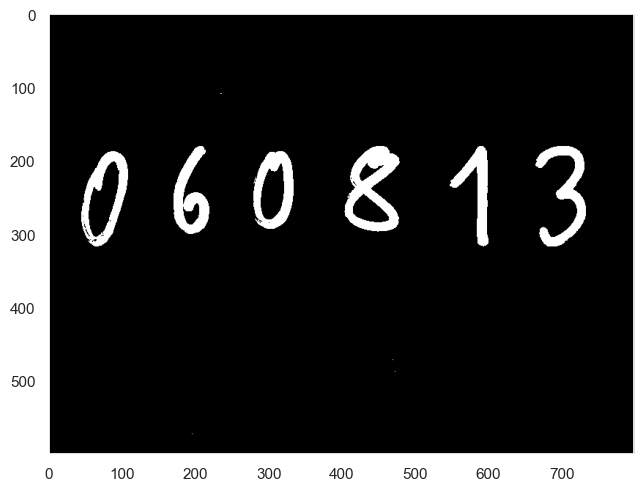

In [9]:
plt.imshow(digits_thresholded, cmap='gray');

In [10]:
digits_opened = cv2.morphologyEx(
    digits_thresholded,
    cv2.MORPH_OPEN,
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
)

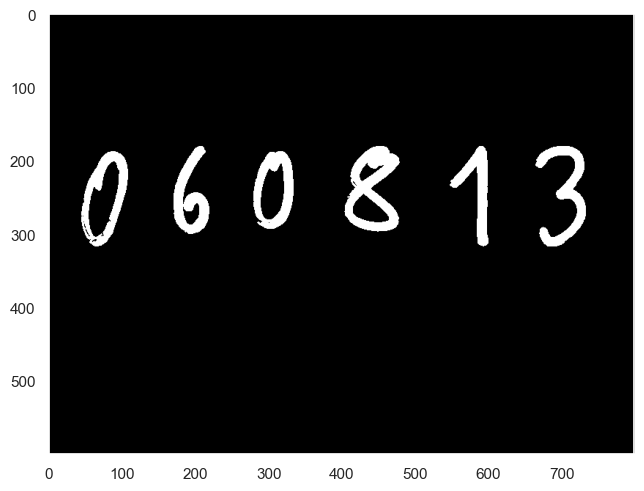

In [11]:
plt.imshow(digits_opened, cmap='gray');

In [12]:
digits_closed = cv2.morphologyEx(
    digits_opened,
    cv2.MORPH_CLOSE,
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
)

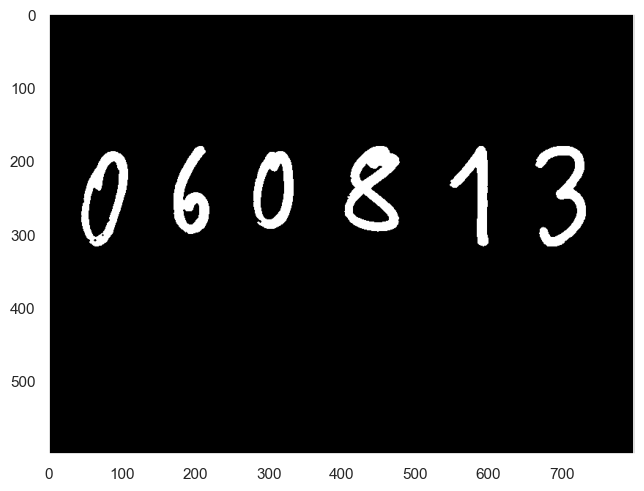

In [13]:
plt.imshow(digits_closed, cmap='gray');

In [14]:
digits_contours, digits_hierarchy = cv2.findContours(digits_closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
len(digits_contours)

13

`cv2.findContours` outputs not only the boundaries of objects, but also their hierarchy. In other words, it tells us which contours are inside which in case there are holes in some of them (holes have their contours too).

In [15]:
digits_hierarchy

array([[[ 2, -1,  1, -1],
        [-1, -1, -1,  0],
        [ 6,  0,  3, -1],
        [ 4, -1, -1,  2],
        [ 5,  3, -1,  2],
        [-1,  4, -1,  2],
        [ 7,  2, -1, -1],
        [ 8,  6, -1, -1],
        [11,  7,  9, -1],
        [10, -1, -1,  8],
        [-1,  9, -1,  8],
        [-1,  8, 12, -1],
        [-1, -1, -1, 11]]], dtype=int32)

The last column specifies index of the parent and when it is `-1`, there is no parent.

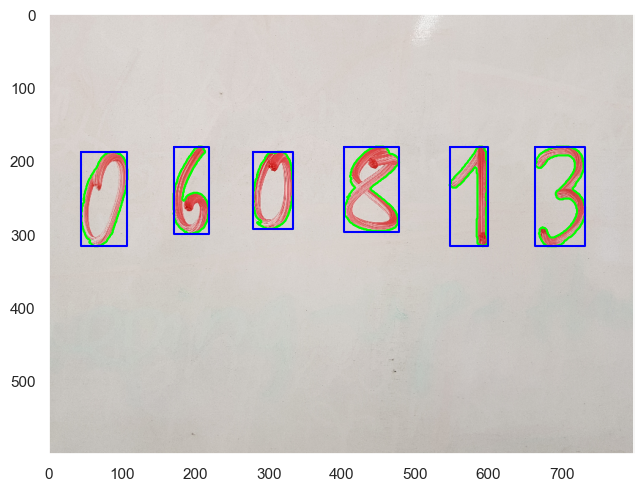

In [16]:
plt.imshow(digits_rgb)

digits = []
for i, c in enumerate(digits_contours):
    # we only want outer contours
    if digits_hierarchy[0, i, 3] > -1:
        continue
    
    # plot the contour
    plt.plot(c[:, 0, 0], c[:, 0, 1], color=(0, 1, 0))
    
    # bounding box
    l, r = c[:, 0, 0].min(), c[:, 0, 0].max()
    t, b = c[:, 0, 1].min(), c[:, 0, 1].max()
    plt.plot([l, r, r, l, l], [t, t, b, b, t], color=(0, 0, 1))
    
    # extract (cut) the digit region from the image
    digits.append(digits_closed[t:b+1, l:r+1])

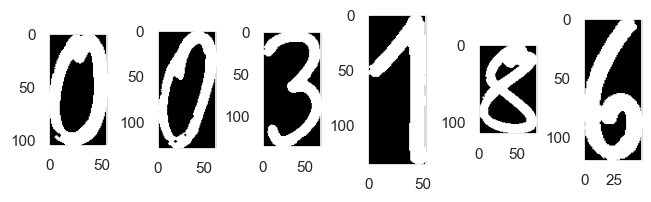

In [17]:
for i, d in enumerate(digits):
    plt.subplot(1, len(digits), i + 1)
    plt.imshow(d, cmap='gray')

# Classification by comparing pixel values

In [18]:
# must normalize to the same size before we can compare pixel-by-pixel
target_size = 50, 100  # width, height
digits = [cv2.resize(d, target_size).astype(float) / 255. for d in digits]

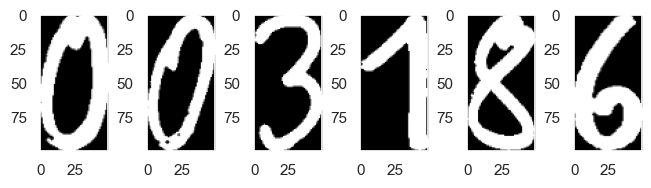

In [19]:
for i, d in enumerate(digits):
    plt.subplot(1, len(digits), i + 1)
    plt.imshow(d, cmap='gray')

In [20]:
# let's say the first digit is unknown
query = digits[0]

In [21]:
# compute euclidean distances from the query to each digit
digits_dists = np.array([np.sum((query - d) ** 2) for d in digits])
digits_dists

array([   0.   , 1151.746, 1779.72 , 1558.929, 1723.171, 1741.133])

In [22]:
# argsort will give us order of the images when compared by their distance to the query
digits_rank = np.argsort(digits_dists)
digits_rank

array([0, 1, 3, 4, 5, 2], dtype=int64)

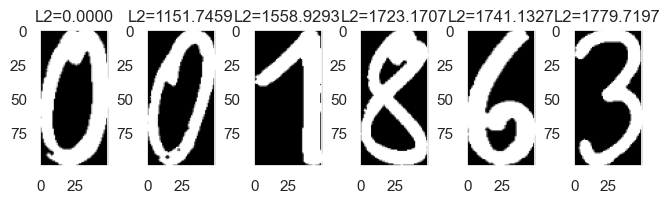

In [23]:
for i, j in enumerate(digits_rank):
    plt.subplot(1, len(digits), i + 1)
    plt.imshow(digits[j], cmap='gray')
    plt.title(f'L2={digits_dists[j]:.4f}')

# Compare all the digits to templates in `20181129_090518.jpg`

In [24]:
template_rgb = cv2.imread('data/20181129_090518.jpg')[..., ::-1]
template_rgb = cv2.resize(template_rgb, (800, 600))

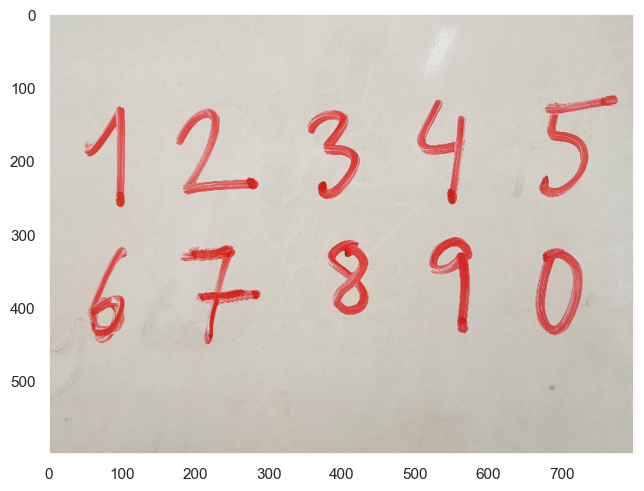

In [25]:
plt.imshow(template_rgb);

Repeat the same preprocessing & extraction procedure for templates. Better way would be to refactor the preprocessing into a function.

In [26]:
# red channel enhancement
template_r = np.uint8(255. * template_rgb[..., 0] / template_rgb.sum(axis=2))

# thresholding using previously determined threshold value
template_thresholded = 255 * np.uint8(template_r > digits_thresh_val - 20)

# morphology
template_opened = cv2.morphologyEx(
    template_thresholded,
    cv2.MORPH_OPEN,
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
)
template_closed = cv2.morphologyEx(
    template_opened,
    cv2.MORPH_CLOSE,
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
)

# find contours
template_contours, template_hierarchy = cv2.findContours(template_closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

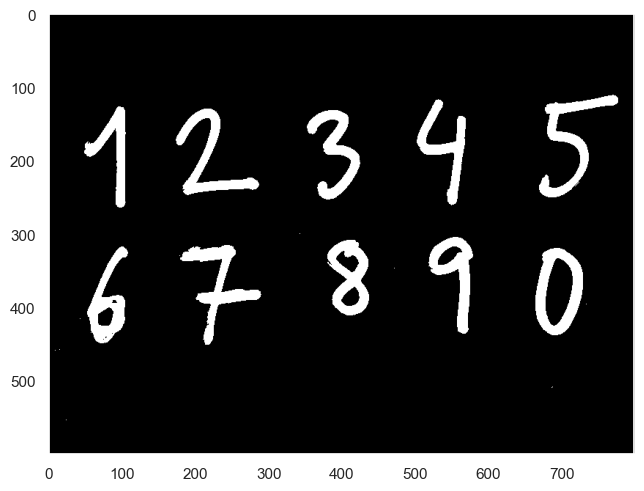

In [27]:
plt.imshow(template_thresholded, cmap='gray');

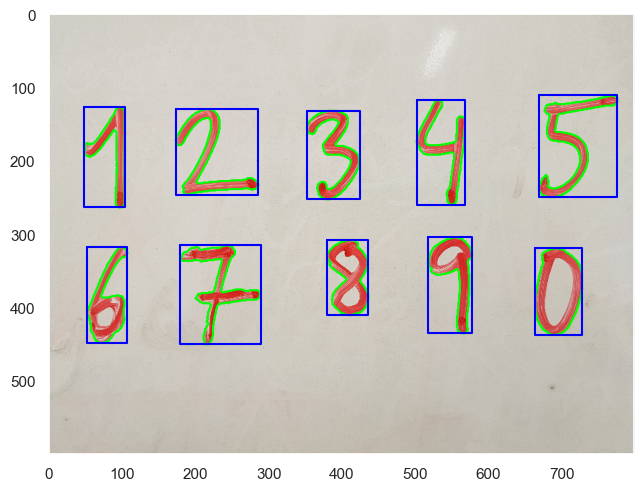

In [28]:
plt.imshow(template_rgb)

templates = []
for i, c in enumerate(template_contours):
    # we only want outer contours
    if template_hierarchy[0, i, 3] > -1:
        continue
    
    # plot the contour
    plt.plot(c[:, 0, 0], c[:, 0, 1], color=(0, 1, 0))
    
    # bounding box
    l, r = c[:, 0, 0].min(), c[:, 0, 0].max()
    t, b = c[:, 0, 1].min(), c[:, 0, 1].max()
    plt.plot([l, r, r, l, l], [t, t, b, b, t], color=(0, 0, 1))
    
    # extract (cut) the digit region from the image and resize
    templates.append(cv2.resize(template_closed[t:b+1, l:r+1], target_size) / 255.)

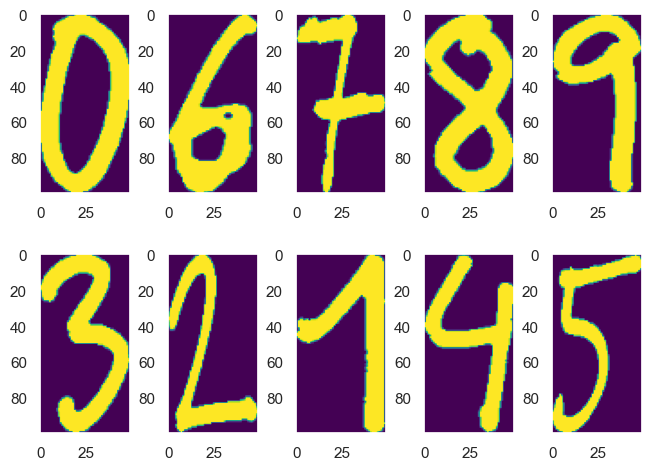

In [29]:
for i, d in enumerate(templates):
    plt.subplot(2, len(templates) // 2, i + 1)
    plt.imshow(d)

In [30]:
template_dists = np.array([
    [np.sum((d - t) ** 2) for t in templates]
    for d in digits
])
template_dists.dtype, template_dists.shape, template_dists.min(), template_dists.max()

(dtype('float64'), (6, 10), 634.0007381776239, 2692.8469050365247)

In [31]:
template_rank = np.argsort(template_dists, axis=1)
template_rank

array([[0, 8, 4, 7, 3, 5, 1, 6, 9, 2],
       [0, 1, 7, 4, 8, 9, 6, 5, 2, 3],
       [5, 4, 8, 2, 0, 6, 3, 9, 7, 1],
       [7, 4, 8, 0, 3, 5, 1, 9, 6, 2],
       [3, 1, 0, 9, 4, 8, 6, 7, 2, 5],
       [1, 3, 0, 6, 7, 9, 5, 2, 8, 4]], dtype=int64)

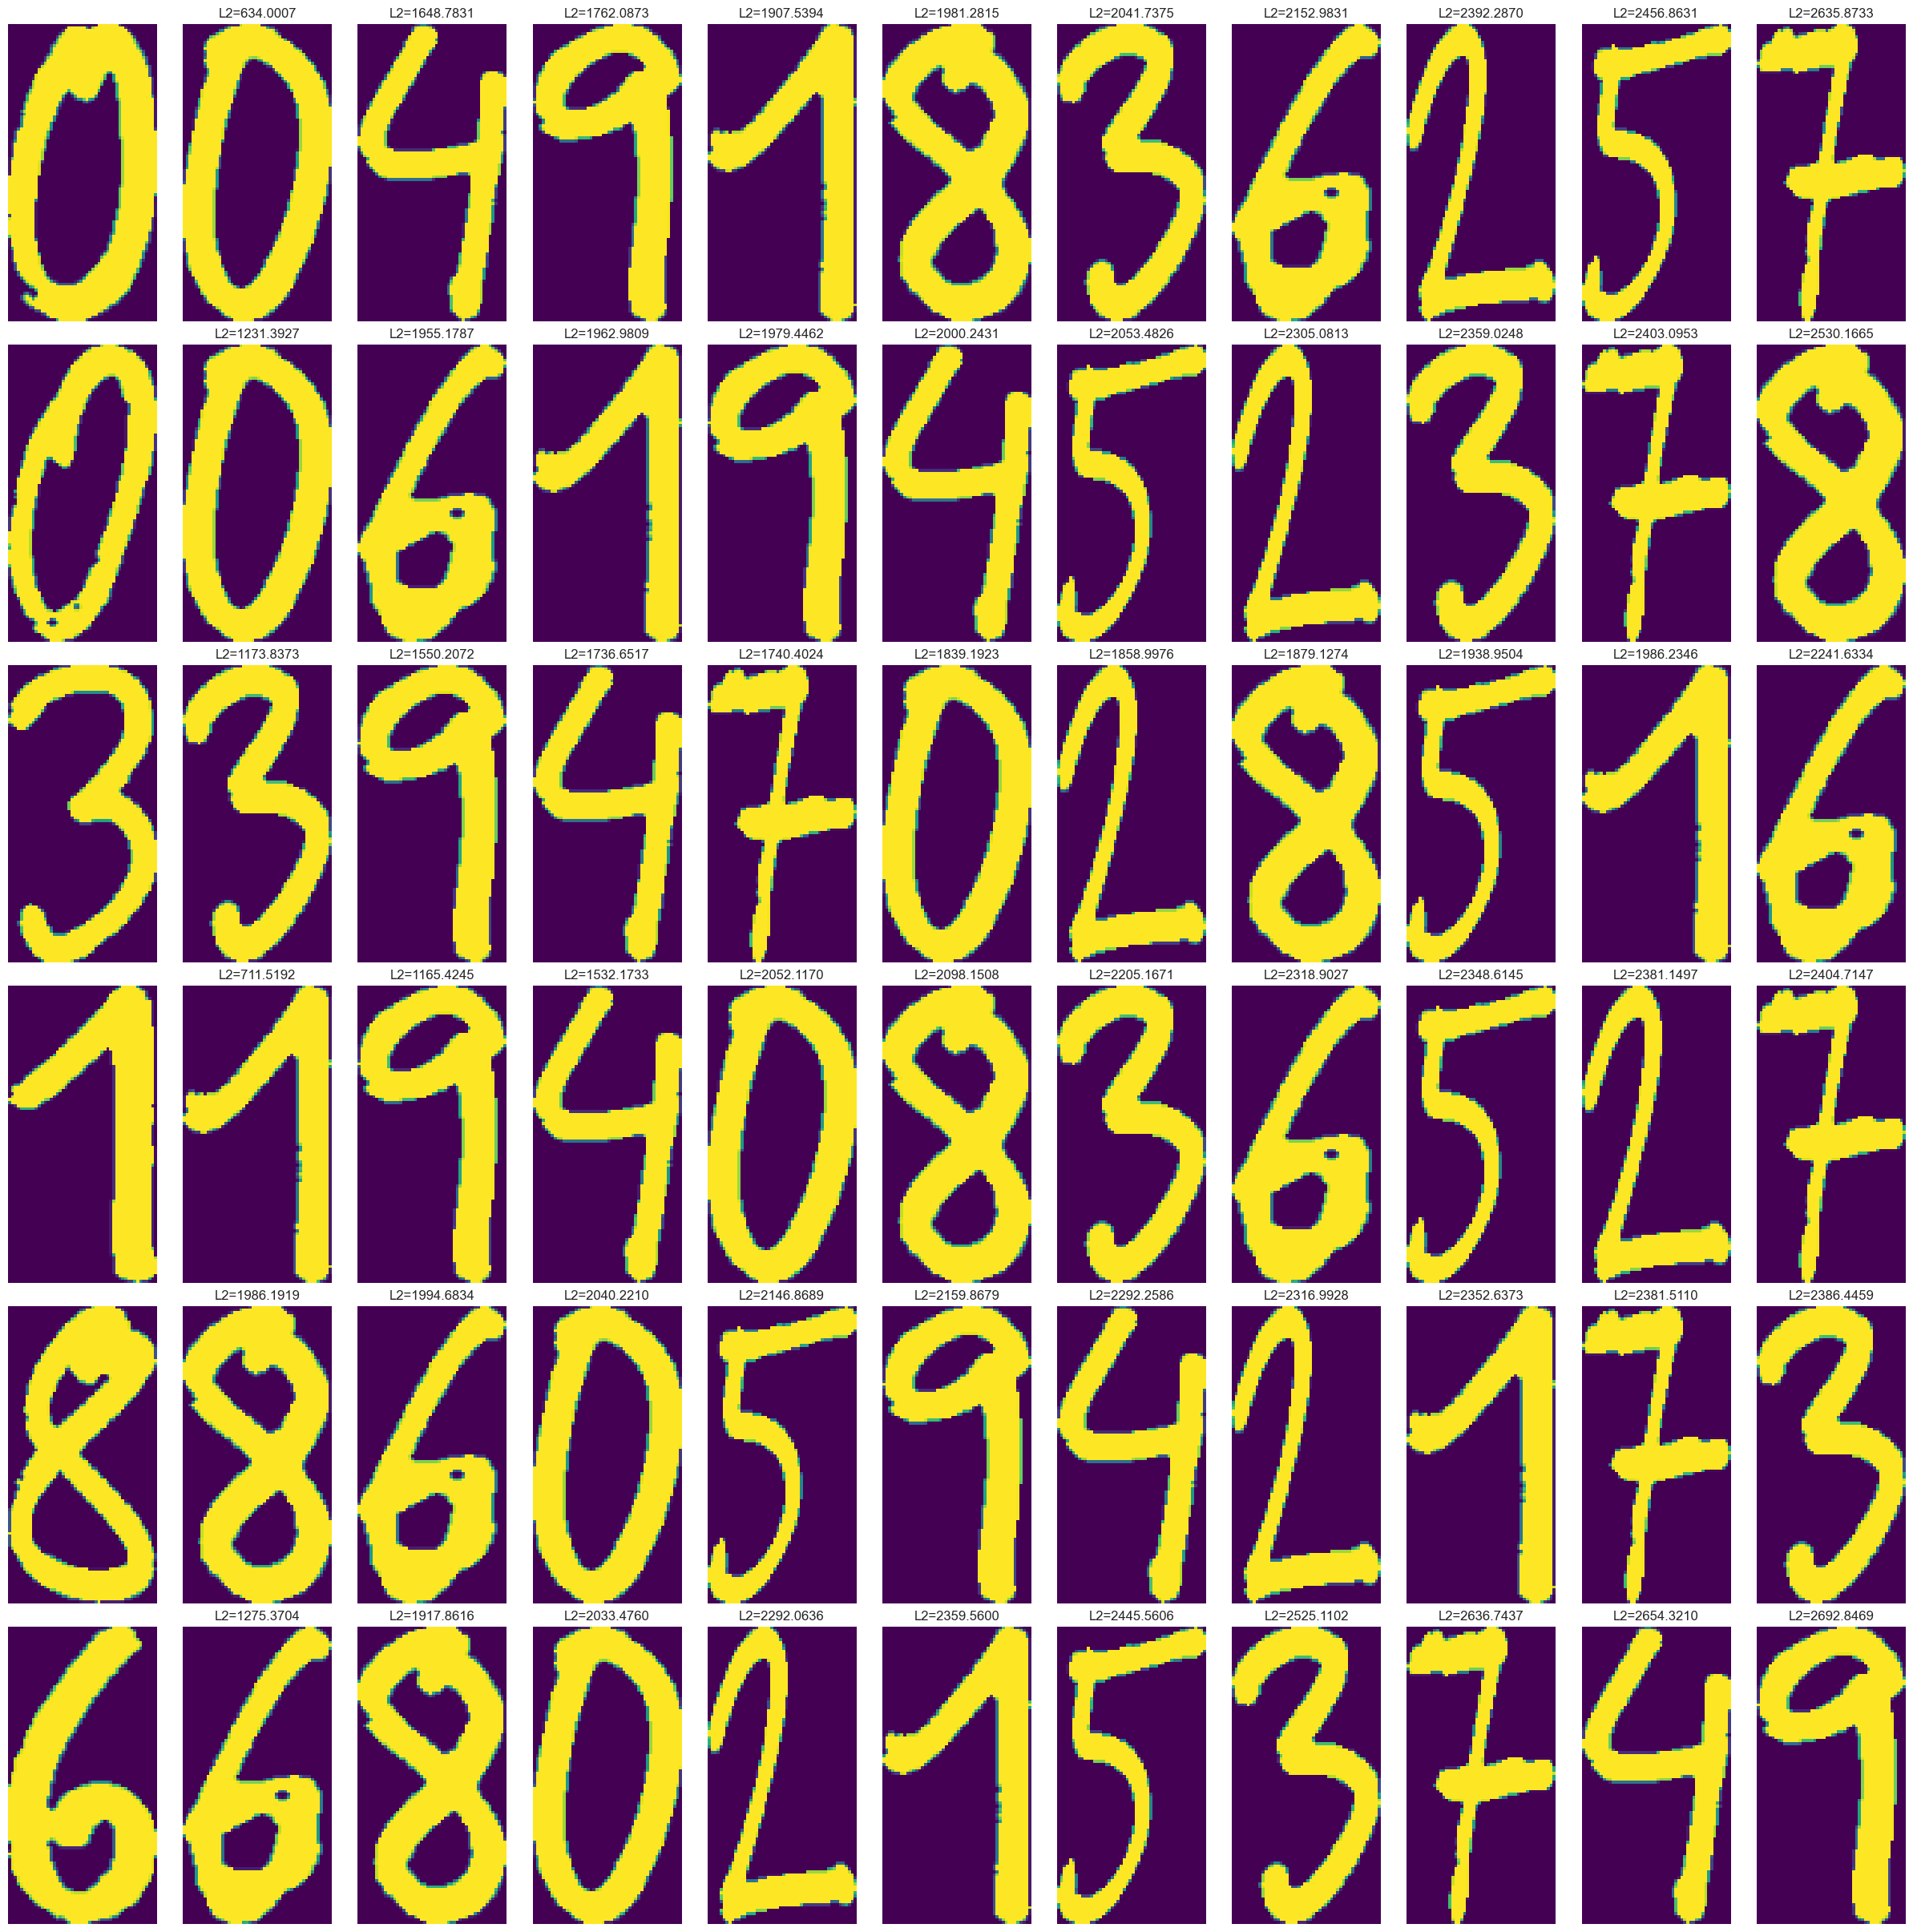

In [32]:
plt.figure(figsize=(24, 24))

for i in range(len(digits)):
    plt.subplot(len(digits), 1 + len(templates), i * (1 + len(templates)) + 1)
    plt.imshow(digits[i])
    plt.axis('off')
    
    for j, k in enumerate(template_rank[i, :]):
        plt.subplot(len(digits), 1 + len(templates), i * (1 + len(templates)) + j + 2)
        plt.imshow(templates[k])
        plt.title(f'L2={template_dists[i, k]:.4f}')
        plt.axis('off')

# Nearest neighbor classifier in `sklearn`

In [33]:
X_train = np.array(templates).reshape(len(templates), -1)
X_train.dtype, X_train.shape, X_train.min(), X_train.max()

(dtype('float64'), (10, 5000), 0.0, 1.0)

In [34]:
y_train = np.array([0, 6, 7, 8, 9, 3, 2, 1, 4, 5])
y_train.dtype, y_train.shape

(dtype('int32'), (10,))

In [35]:
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1, algorithm='brute')
knn

KNeighborsClassifier(algorithm='brute', n_neighbors=1)

In [36]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', n_neighbors=1)

In [37]:
X_valid = np.array(digits).reshape(len(digits), -1)
X_valid.dtype, X_valid.shape, X_valid.min(), X_valid.max()

(dtype('float64'), (6, 5000), 0.0, 1.0)

In [38]:
y_valid = np.array([0, 0, 3, 1, 8, 6])
y_valid.dtype, y_valid.shape

(dtype('int32'), (6,))

In [39]:
y_pred = knn.predict(X_valid)
y_pred

array([0, 0, 3, 1, 8, 6])

In [40]:
# calculate accuracy
np.sum(y_pred == y_valid) / len(y_valid)

1.0